# Wetter API

In [38]:
import requests # Library to access URLs using Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator

## Get Forcast weather data

### Get data

In [39]:
def build_query_string(base_url, params_dict):
    # Create a string of param1=value1&param2=value2&...
    params_str = "&".join(f"{k}={v}" for k,v in params_dict.items())
    # Concatenate this string with the base URL and return
    return f"{base_url}?{params_str}"

In [40]:
# Set our API key
api_key = "ba6cf0fabcb9f0ec1029c1a0a7949ec4"

In [41]:
# Let's start with the first step: finding the latitude and longitude for a given city

# Define the base URL of the geolocation API
geo_url = "http://api.openweathermap.org/geo/1.0/direct"

# Define the parameters of our query 
# (see the documentation: https://openweathermap.org/api/geocoding-api#direct)
geo_params = {
    "q": "Köln",
    "appid": api_key
}

# Create the API query URL
query = build_query_string(geo_url, geo_params)

# Obtain the data from the API call
geo_data = requests.get(query).json()

In [42]:
# Transform a date_string to its Unix time format
# Date format should be YYYY-MM-DD or specified accordingly
def date_to_unix(date_string, date_format="%Y-%m-%d"):
    date = dt.datetime.strptime(date_string, date_format)
    return int(dt.datetime.timestamp(date))

# It will also be useful to transf

In [43]:
# Define the base URL of the forecast API
forcast_url = "https://api.openweathermap.org/data/2.5//forecast"



# Define the parameters of our query to the air pollution API
airpol_params = {
    "lat": geo_data[0]["lat"], # The latitude of our chosen city
    "lon": geo_data[0]["lon"], # The longitude of our chosen city
    "appid": api_key, # Our API key
    "units": "metric"

}

weather = requests.get(build_query_string(forcast_url, airpol_params)).json()

In [44]:
# Extract a list of relevant dictionaries
observations_temp = []
observations_weather = []

for datapoint in weather["list"]:
    # Keep track of all air pollution variables
    obs_t = datapoint["main"]#["temp"]
    # Add the date to the dictionary as well
    obs_t["date"] = datapoint["dt"]
    # Add the observation to our full list of observations
    observations_temp.append(obs_t)
        # Keep track of all air pollution variables
    obs_w = datapoint["weather"][0]#["description"]
    # Add the date to the dictionary as well
    obs_w["date"] = datapoint["dt"]
    # Add the observation to our full list of observations
    observations_weather.append(obs_w)

In [45]:
# Saving data from API in a Dataframe to merge
df_t = pd.DataFrame.from_records(observations_temp)
df_w = pd.DataFrame.from_records(observations_weather)


In [46]:
# Merging data and changing date formate
df = pd.merge(df_t, df_w, how= "right", on = "date")
df["date"] = pd.to_datetime(df["date"], unit="s")

# buildng this as hourly with cloned rows
df_repeated = pd.concat([df]*3, ignore_index=True)
df_repeated.loc[[0,40,80]]

new_index = []


#Changing the Dataframe to every hour
for n in range(int(len(df_repeated)/3)):
    new_index.append(n)
    new_index.append(n+40)
    new_index.append(n+80)

df_repeated = df_repeated.reindex(new_index)
df_repeated.reset_index(inplace = True, drop = True)

# Getting a step by step change in temperature
for n in range(int(len(df_repeated)/3)-1):
    start_index = n*3
    end_index = (n*3)+3
    start = df_repeated.loc[start_index,"temp"]
    end = df_repeated.loc[end_index,"temp"]
    difference = end - start
    steps = round(difference/3,2)
    df_repeated.loc[start_index+1,"temp"] = df_repeated.loc[start_index,"temp"] + steps
    df_repeated.loc[start_index+2,"temp"] = df_repeated.loc[start_index,"temp"] + steps + steps

df_repeated = df_repeated.drop(df_repeated.iloc[:,1:9],axis = 1)
df_repeated


,temp,date,id,main,description,icon
0,6.19,2022-12-01 15:00:00,803,Clouds,broken clouds,04d
1,6.14,2022-12-01 15:00:00,803,Clouds,broken clouds,04d
2,6.09,2022-12-01 15:00:00,803,Clouds,broken clouds,04d
3,6.03,2022-12-01 18:00:00,803,Clouds,broken clouds,04n
4,6.01,2022-12-01 18:00:00,803,Clouds,broken clouds,04n
...,...,...,...,...,...,...
115,3.69,2022-12-06 09:00:00,500,Rain,light rain,10d
116,3.72,2022-12-06 09:00:00,500,Rain,light rain,10d
117,3.74,2022-12-06 12:00:00,804,Clouds,overcast clouds,04d
118,3.74,2022-12-06 12:00:00,804,Clouds,overcast clouds,04d


### Prepearing hourly

In [47]:
# Setting the Hour intervals for the Dataframe
for n in range(int(len(df_repeated)/3)):
    start_index = n*3
    df_repeated.loc[start_index+1,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=1)
    df_repeated.loc[start_index+2,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=2)

# Splitting the date and time for a merge
df_repeated["date"] = df_repeated["date"].astype(str)
df_repeated[["date", "time"]] = df_repeated["date"].str.split(" ", n=1, expand=True)
df_repeated

#Get Column with months
df_repeated["months"] = df_repeated["date"].str.slice(5, 7)

#Transform time to hours
df_repeated["hour"] = df_repeated["time"].str.slice(0, 2)

### School Holiday

In [48]:
#Import datapackages
from datetime import date, timedelta
from datetime import datetime

#Import Dataframe from the holidays
future_school_holi = pd.read_csv("future_school_holiday.csv", sep = ";")
days_df_list = []

#Create dataframe with all dates singular listed 
for i in range(future_school_holi.shape[0]):
    #Get the start and enddate from the holidays
    start_date = datetime.strptime(future_school_holi["Erster Ferientag"][i], "%Y-%m-%d").date()
    end_date = datetime.strptime(future_school_holi["Letzter Ferientag"][i], "%Y-%m-%d").date()

    #create dataframes out of the range and append to a list
    delta = end_date - start_date
    days = [start_date + timedelta(days=n) for n in range(delta.days + 1)]
    days_df = pd.DataFrame (days, columns = ["date"])
    days_df_list.append(days_df)

#create single dataframe out of the list and add value 1 for holiday
new_holi = pd.concat(days_df_list).reset_index(drop=True)
new_holi["school holiday"] = 1

#Chagne to str for merge
new_holi["date"] = new_holi["date"].astype(str)





In [49]:
# Merging the weather data an the holidays
df_merge1 = pd.merge(df_repeated, new_holi, how= "left", on = "date")
# Filling cells with no holiday with a 0
df_merge1["school holiday"] = df_merge1["school holiday"].fillna(0)
# change float to int
df_merge1["school holiday"] = np.int64(df_merge1["school holiday"].astype(int))
df_merge1

,temp,date,id,main,description,icon,time,months,hour,school holiday
0,6.19,2022-12-01,803,Clouds,broken clouds,04d,15:00:00,12,15,0
1,6.14,2022-12-01,803,Clouds,broken clouds,04d,16:00:00,12,16,0
2,6.09,2022-12-01,803,Clouds,broken clouds,04d,17:00:00,12,17,0
3,6.03,2022-12-01,803,Clouds,broken clouds,04n,18:00:00,12,18,0
4,6.01,2022-12-01,803,Clouds,broken clouds,04n,19:00:00,12,19,0
...,...,...,...,...,...,...,...,...,...,...
115,3.69,2022-12-06,500,Rain,light rain,10d,10:00:00,12,10,0
116,3.72,2022-12-06,500,Rain,light rain,10d,11:00:00,12,11,0
117,3.74,2022-12-06,804,Clouds,overcast clouds,04d,12:00:00,12,12,0
118,3.74,2022-12-06,804,Clouds,overcast clouds,04d,13:00:00,12,13,0


### National Holiday

In [50]:
from datetime import date, timedelta

# Getting the current year 
today = dt.date.today()
year = int(today.strftime("%Y"))

# Putting this and the next year into a list to claculate the holidays
this_plus_next_year = [year,year + 1]

future_holidays_list = []

for intput_year in this_plus_next_year:
    #Formular for calculating easter sunday
    k = intput_year // 100
    m = 15 + (3 * k + 3) // 4 - (8 * k + 13) // 25
    s = 2 - (3*k + 3) // 4
    a = intput_year % 19

    d = (19* a + m) % 30
    r = (d + a // 11) // 29
    og = 21 + d - r
    sz = 7 - (intput_year + intput_year // 4 + s) % 7

    oe =  7 - (og - sz) % 7

    #days for easter sunday after teh first march (because daytime starts at first minus 1 again)
    os = og + oe -1
    first_march = date(intput_year, 3, 1)

    # calculating the date for easter sunday
    os_date = first_march + timedelta(days=os)


    # The flexible holidays calculated from easter sunday
    karfreitag = os_date - timedelta(days=2)
    os_date = os_date
    easter_monday = os_date + timedelta(days=1)
    ascension = os_date + timedelta(days=39)
    white_monday = os_date + timedelta(days=50)
    corpus_christ = os_date + timedelta(days=60)

    # The fixed holidays (for nrw)
    new_year = date(intput_year, 1, 1)
    day_of_work = date(intput_year, 5, 1)
    germany_united = date(intput_year, 10, 3)
    saints_day = date(intput_year, 11, 1)
    first_christmas = date(intput_year, 12, 25)
    second_christmas =date(intput_year, 11, 26)

    # Creating dataframe with holidays
    holiday_list_future = [new_year, karfreitag, os_date, easter_monday, day_of_work, ascension, white_monday, corpus_christ, germany_united, saints_day, first_christmas, second_christmas]
    future_holidays = pd.DataFrame ({"date": holiday_list_future,
                                    "holiday": [1 for i in range(len(holiday_list_future))]})
    future_holidays_list.append(future_holidays)

# connect the holidays from this and the nex year
df_future_holidays = pd.concat(future_holidays_list)

In [51]:
# Merging the holidays with the alredy merged dataframe
df_merge2 = pd.merge(df_merge1, df_future_holidays, how= "left", on = "date")
# Fill no holidays with zeros
df_merge2["holiday"] = df_merge2["holiday"].fillna(0)
#change float to int
df_merge2["holiday"] = np.int64(df_merge2["holiday"].astype(int))

### Getting the training data for Pedestriants

In [52]:
#Getting the Dataframe for the prediction without pca
ped = pd.read_csv("data_clean_without_dummies.csv", sep = ";")
ped.drop(["Unnamed: 0"], axis = 1, inplace = True)
ped

,date,time,weekday,pedestrians count,temperature in ºc,weather condition,holiday,school holiday,months,hour
0,2018-05-01,00:00:00,Tuesday,0,8.0,partly-cloudy-night,1,0,5,0
1,2018-05-01,01:00:00,Tuesday,0,7.0,partly-cloudy-night,1,0,5,1
2,2018-05-01,02:00:00,Tuesday,146,7.0,partly-cloudy-night,1,0,5,2
3,2018-05-01,03:00:00,Tuesday,125,7.0,partly-cloudy-night,1,0,5,3
4,2018-05-01,04:00:00,Tuesday,84,6.0,partly-cloudy-night,1,0,5,4
...,...,...,...,...,...,...,...,...,...,...
15353,2020-01-31,19:00:00,Friday,5422,11.0,partly-cloudy-night,0,0,1,19
15354,2020-01-31,20:00:00,Friday,2691,11.0,partly-cloudy-night,0,0,1,20
15355,2020-01-31,21:00:00,Friday,1329,10.0,partly-cloudy-night,0,0,1,21
15356,2020-01-31,22:00:00,Friday,915,11.0,cloudy,0,0,1,22


In [53]:
#Putting the holidays in the last two places to mak it easier to assign the parameters for learning
ped = ped.reindex(columns = [col for col in ped.columns if col != "school holiday"] + ["school holiday"])
ped = ped.reindex(columns = [col for col in ped.columns if col != "holiday"] + ["holiday"])
ped

,date,time,weekday,pedestrians count,temperature in ºc,weather condition,months,hour,school holiday,holiday
0,2018-05-01,00:00:00,Tuesday,0,8.0,partly-cloudy-night,5,0,0,1
1,2018-05-01,01:00:00,Tuesday,0,7.0,partly-cloudy-night,5,1,0,1
2,2018-05-01,02:00:00,Tuesday,146,7.0,partly-cloudy-night,5,2,0,1
3,2018-05-01,03:00:00,Tuesday,125,7.0,partly-cloudy-night,5,3,0,1
4,2018-05-01,04:00:00,Tuesday,84,6.0,partly-cloudy-night,5,4,0,1
...,...,...,...,...,...,...,...,...,...,...
15353,2020-01-31,19:00:00,Friday,5422,11.0,partly-cloudy-night,1,19,0,0
15354,2020-01-31,20:00:00,Friday,2691,11.0,partly-cloudy-night,1,20,0,0
15355,2020-01-31,21:00:00,Friday,1329,10.0,partly-cloudy-night,1,21,0,0
15356,2020-01-31,22:00:00,Friday,915,11.0,cloudy,1,22,0,0


### Weather

In [54]:
#Values from weather and key from ped. data
#Athomsphere is not exectly fog but also and the rest does not accure in Köln
# 
######################################################
#ICH HABE WIND UND NIESELREGEN GLEICHGESETZT?? UND THUNDERSTORM AGAIN WITH RIAN
######################################################
dict_weather = {'rain':"Thunderstorm",
                'wind':"Drizzle",
                'rain':"Rain",
                "snow":"Snow",
                "fog":'Atmosphere',
                "clear-night":"Clear",
                "clear-day":"Clear",
                "cloudy":"Clouds",
                "partly-cloudy-night":"Clouds",
                "partly-cloudy-day":"Clouds",
                "nan":"nan"}

#Create columns with rows for zero, becuase we dont use get_dummies, to be sure it is not mixing the rows up
for weather_condition in dict_weather.values():
    df_merge2[weather_condition] = 0
    ped[weather_condition] = 0


# Changing the 0 to a 1 in the Weather Columns for the weather data
for i in range(len(df_merge2)):
    weather = df_merge2.loc[i, "main"]
    for weather_types in dict_weather.values():
        if weather == weather_types:
            df_merge2.loc[i, weather_types] = 1




#Changing the 0 to a 1 in the Weather Columns for the pedestirants data
for i in range(len(ped)):
    weather = ped.loc[i, "weather condition"]
    for weather_types in dict_weather.keys():
        if weather == weather_types:
            value = next((v for k, v in dict_weather.items() if k == weather), "nan")
            ped.loc[i, value] = 1


### Months

In [55]:
# Create a function to create and fill the Columns of the months
def fill_months(data_frame, Month_list, Column):
    for month in Month_list:
        data_frame[month] = 0
    for i in range(len(data_frame)):
        month = data_frame.loc[i, Column]
        for number_months in range(len(Month_list)):
            number_months_str = str(number_months+1).zfill(2)
            if month == number_months_str:
                df_merge2.loc[i, Month_list[number_months]] = 1

In [56]:
# Create a list wiht all months
Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Using the function for the Weatherdata
fill_months(df_merge2, Months, "months")

# Using the function for the Pedestirants data
fill_months(ped, Months, "months")

### Weekdays

In [57]:
# Create a function to create and fill the Columns of the months
def fill_weekdays(data_frame, Weekdays_list, Column):
    for days in Weekdays_list:
        data_frame[days] = 0
    for i in range(len(data_frame)):
        if Column == "weekday":
            day = ped.loc[i, "weekday"]
        if Column != "weekday":
            day = datetime.strptime(df_merge2.loc[i, "date"], "%Y-%m-%d").strftime('%A')
        for weekday in Weekdays_list:
            if day == weekday:
                data_frame.loc[i, weekday] = 1



In [58]:
#Create list with weekdays
Weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Using the function for the Weatherdata
fill_weekdays(df_merge2, Weekdays, "date")

# Using the function for the Pedestrian Data
fill_weekdays(ped, Weekdays, "weekday")


### Hours 

In [59]:
# Create a function to create and fill the Columns of the months
def fill_hours(data_frame, Column):
    # Creating columns with the hours and setting them 0
    hour_in_day =  list(data_frame[Column].unique())
    hour_in_day.sort()
    for time in hour_in_day:
      data_frame[time] = 0
    # Going over the dataframe and changing to 1
    for i in range(len(data_frame)):
        time = data_frame.loc[i, Column]
        for hour in hour_in_day:
            if time == hour:
                data_frame.loc[i, time] = 1

In [60]:
# Using the function for the Weatherdata
fill_hours(df_merge2, "time")

# Using the function for the Weatherdata
fill_hours(ped, "time")

### Temperature

In [61]:
standardize = lambda x: (x - x.mean()) / x.std()

mean_used = ped["temperature in ºc"].mean()
std_used = ped["temperature in ºc"].std()

# Standadize the ped Temperature
ped["temperature"] = (ped["temperature in ºc"] - mean_used) / std_used

# Standadize the Weather Temperature
df_merge2["temperature"] = (df_merge2["temp"] - mean_used) / std_used


## Final

### Training Data

In [62]:
# Define a X
X = ped[ped.columns[8:]]
# Output to predict
y = ped["pedestrians count"]


# Define a X for the forecast
X_forecast = df_merge2[df_merge2.columns[9:]]


# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [63]:
examplatory_forecast_model = RandomForestRegressor(random_state=144,n_jobs=-1)
examplatory_forecast_model.fit(Xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=144)

In [64]:
def get_mae(y_data, x_data, model):
    mae = mean_absolute_error(y_data, model.predict(x_data))
    return mae
    
mae_train = get_mae(ytrain, Xtrain, examplatory_forecast_model)
mae_test = get_mae(ytest, Xtest, examplatory_forecast_model)

print(mae_train, mae_test)

289.7869579507899 524.6223471023936


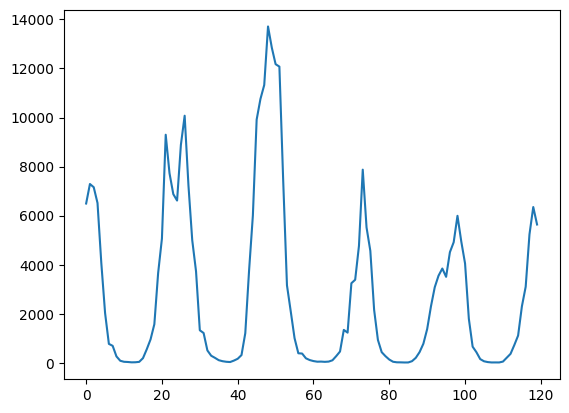

In [65]:
forecast = examplatory_forecast_model.predict(X_forecast)

forecast = [int(round(item, 0)) for item in forecast]


df_merge2["forecast"] = forecast

plt.plot(forecast)


In [66]:
df_merge2

,temp,date,id,main,description,icon,time,months,hour,school holiday,...,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,temperature,forecast
0,6.19,2022-12-01,803,Clouds,broken clouds,04d,15:00:00,12,15,0,...,0,0,0,0,0,0,0,0,-0.853787,6495
1,6.14,2022-12-01,803,Clouds,broken clouds,04d,16:00:00,12,16,0,...,1,0,0,0,0,0,0,0,-0.860286,7290
2,6.09,2022-12-01,803,Clouds,broken clouds,04d,17:00:00,12,17,0,...,0,1,0,0,0,0,0,0,-0.866784,7160
3,6.03,2022-12-01,803,Clouds,broken clouds,04n,18:00:00,12,18,0,...,0,0,1,0,0,0,0,0,-0.874583,6516
4,6.01,2022-12-01,803,Clouds,broken clouds,04n,19:00:00,12,19,0,...,0,0,0,1,0,0,0,0,-0.877183,4076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,3.69,2022-12-06,500,Rain,light rain,10d,10:00:00,12,10,0,...,0,0,0,0,0,0,0,0,-1.178729,2305
116,3.72,2022-12-06,500,Rain,light rain,10d,11:00:00,12,11,0,...,0,0,0,0,0,0,0,0,-1.174830,3103
117,3.74,2022-12-06,804,Clouds,overcast clouds,04d,12:00:00,12,12,0,...,0,0,0,0,0,0,0,0,-1.172230,5238
118,3.74,2022-12-06,804,Clouds,overcast clouds,04d,13:00:00,12,13,0,...,0,0,0,0,0,0,0,0,-1.172230,6353
